# Introduction to Natural Language Processing and Recurrent Neural Networks

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import (Input, Dense, Embedding, Flatten, SimpleRNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Simple Recurrent Neural Networks (RNNs) <div id='rnn_intro'>



An RNN is similar to a FFNN in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Here's a popular blog post on [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).


In Keras, the vanilla RNN unit is implemented the`SimpleRNN` layer:
```
tf.keras.layers.SimpleRNN(
    units, activation='tanh', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, **kwargs
)
```
For more details check Keras' documention https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN.

As you can see, recurrent layers in Keras take many arguments. We only need to be concerned with `units`, which specifies the size of the hidden state. 

Simple RNNs have some serious problems and limitations.  Due to these limitations, simple RNN unit tends not to be used much in practice. For this reason it seems that the Keras developers neglected to implement GPU acceleration for this layer.

## Time-series prediction <div id = 'timeSeries'>
    
RNNs become effective in learning from sequential data like time series and text. Let's start this journey in RNNs by predicting a noisy time series. 

Generate some synthetic sequential noisy data

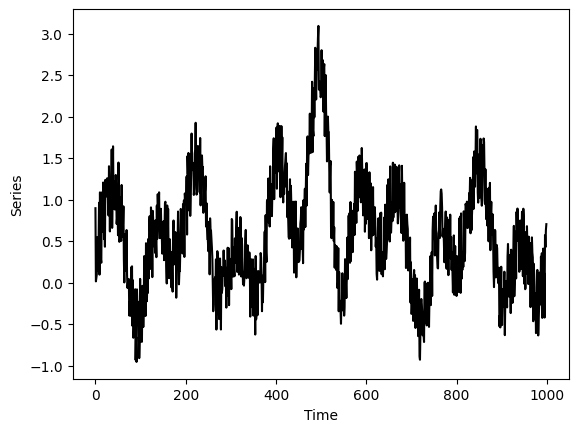

In [2]:
N = 1000
Tp = 800

t = np.arange(0, N)

x = np.sin(0.02 * t) * 1 * np.sin(0.05 * t) + 2 * np.exp(-((t - 500) ** 2) / 1000)
# Add gaussian (white) noise
x += np.random.rand(N)

df = pd.DataFrame(x)

plt.plot(t, x, "k")
plt.xlabel("t")
plt.xlabel("x")
plt.xlabel("Time")
plt.ylabel("Series")
plt.show()

#### Split data into training and testing sets
Note, this is forecasting, so we do not know the future 

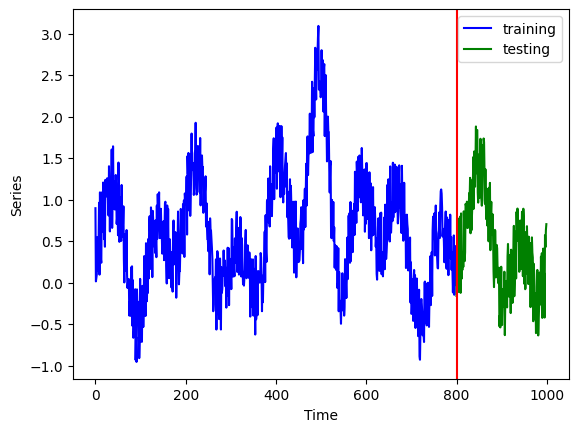

In [3]:
values = df.values
train, test = values[0:Tp, :], values[Tp:N, :]

plt.plot(df[0:Tp], "b", label="training")
plt.plot(df[Tp:N], "g", label="testing")

plt.axvline(df.index[Tp], c="r")
plt.xlabel("Time")
plt.ylabel("Series")
plt.legend()
plt.show()

#### Prepare the data

RNNs  require a step value that contains `n` number of elements as an input sequence. Here, we define it as a `step`. 
Let's understand this concept through  two simple cases. Cosidere the input `x` and the output `y`:
- For step=1: 
   - x=[1,2,3,4,5]
   - y=[2,3,4,5,6]
- For step=2: 
   - x=[ (1,2), (2,3), (3,4) (4,5) ]
   - y=[3,4,5,6]

   

The sizes of `x`  and `y` are  different. We can  fix this by adding step size into the training and test data.


In [4]:
print(train.shape, test.shape)

(800, 1) (200, 1)


In [5]:
step = 4
# add step elements into train and test
test = np.append(test, np.repeat(test[-1,], step))
train = np.append(train, np.repeat(train[-1,], step))

In [6]:
print(train.shape, test.shape)

(804,) (204,)


Convert the datasets into the matrix with step value as it has shown above explation.


In [7]:
def convertToMatrix(data, step):
    X, Y = [], []
    for i in range(len(data) - step):
        d = i + step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)


trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

print("Shapes of the training dataset for (x,y): ", trainX.shape, trainY.shape)
print("Shapes of the testing dataset for (x,y) : ", testX.shape, testY.shape)

Shapes of the training dataset for (x,y):  (800, 4) (800,)
Shapes of the testing dataset for (x,y) :  (200, 4) (200,)


Finally, we reshape `trainX` and `testX` to fit with the Keras RNN model that  requires three-dimensional input data.



In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(800, 1, 4) (200, 1, 4)


In [9]:
model = Sequential()
model.add(Input(shape=(1, step)))
# Here, we add the RNN unit. Keras makes it easy for us
model.add(SimpleRNN(units=32, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1457 (5.69 KB)
Trainable params: 1457 (5.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# concate train and test predictions for plotting purposes
predicted = np.concatenate((trainPredict, testPredict), axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX, testY, verbose=0)
print("Train score: ", trainScore)
print("Test score: ", testScore)

7/7 [==============================] - 0s 583us/step
Train score:  0.09729823470115662
Test score:  0.10916657745838165


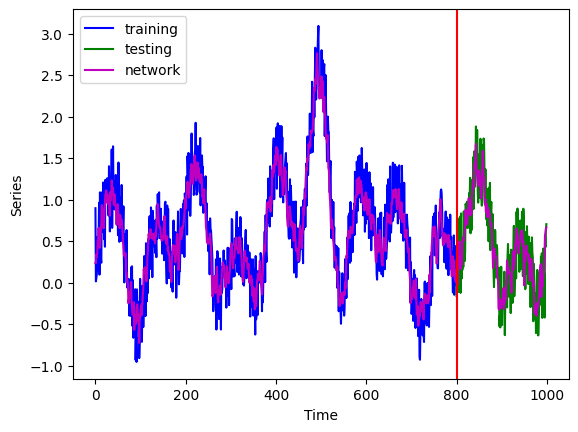

In [11]:
index = df.index.values
plt.plot(df[0:Tp], "b", label="training")
plt.plot(df[Tp:N], "g", label="testing")
plt.plot(predicted, "m", label="network")
plt.axvline(df.index[Tp], c="r")
plt.xlabel("Time")
plt.ylabel("Series")
plt.legend()

## Neural Networks for NLP

Let's frame our introduction to NLP around the example of a text classifier. Specifically, we'll build and evaluate various models that all attempt to descriminate between positive and negative reviews through the Internet Movie Database (IMDB).

The IMDB dataset is very popular so `keras` also includes an alternative method for loading the data. This method can save us a lot of time for many reasons:
- Cleaned text with less meaningless punctuation
- Pre-tokenized and numerically encoded
- Allows us to specify maximum vocabulary size
- more ...

#### Load clean data

In [12]:
# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
MAX_VOCAB = 10000
INDEX_FROM = 3  # word index offset
(X_train, y_train), (X_test, y_test) = imdb.load_data(
    num_words=MAX_VOCAB, index_from=INDEX_FROM
)

`get_word_index` will load a json object we can store in a dictionary. This gives us the word-to-integer mapping.

In [13]:
word2idx = imdb.get_word_index(path="imdb_word_index.json")
word2idx = {k: (v + INDEX_FROM) for k, v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
word2idx["<UNUSED>"] = 3
word2idx

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [14]:
idx2word = {v: k for k, v in word2idx.items()}
idx2word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

We can see that the text data is already preprocessed for us.

In [15]:
print("Number of reviews", len(X_train))
print(
    "Length of first and fifth review before padding",
    len(X_train[0]),
    len(X_train[4]),
    "\n",
)
print("First review: ", X_train[0], "\n")
print("First label: ", y_train[0], "\n")

Number of reviews 25000
Length of first and fifth review before padding 218 147 

First review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113,

Here is an example review using the index-to-word mapping we created from the loaded JSON file to view the a review in its original form.

In [16]:
def show_review(x):
    review = " ".join([idx2word[idx] for idx in x])
    print(review)


show_review(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

Keras has a built in `pad_sequences` helper function. This handles both padding and truncating. By default padding is added to the *beginning* of a sequence.

In [17]:
MAX_LEN = 500
X_train = pad_sequences(
    X_train, maxlen=MAX_LEN, padding="pre"
)  # padding='post' will pad in the end of a sequence
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding="pre")
print(
    "Length of first and fifth review after padding", len(X_train[0]), len(X_train[4])
)
print("Note that earlier the lenghts were 218 and 147.")

Length of first and fifth review after padding 500 500
Note that earlier the lenghts were 218 and 147.


In [18]:
print((X_train.shape))
X_train[0]

(25000, 500)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Model 1: Naive Feed-Forward Network <div id='FFNN'></div>

In [19]:
model = Sequential(name="Naive_FFNN")
model.add(Dense(250, activation="relu", input_dim=MAX_LEN))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=2,
)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 125501 (490.24 KB)
Trainable params: 125501 (490.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
196/196 - 1s - loss: 164.3027 - accuracy: 0.5072 - val_loss: 80.0463 - val_accuracy: 0.5023 - 571ms/epoch - 3ms/step
Epoch 2/10
196/196 - 0s - loss: 38.4028 - accuracy: 0.5899 - val_loss: 37.2181 - val_accuracy: 0.5069 - 351ms/epoch - 2ms/step
Epoch 3/10
196/196 - 0s - loss: 12.5956 - accuracy: 0.6625 - val_loss: 20.8608 - val_accuracy: 0.5090 - 389ms/epoch - 2ms/step
Epoch 4/10
196/196 - 0s -

## Model 2: Feed-Forward Network with Embeddings

<img src='figs/wordembedding2.png' width=450px>

    
    
Embedding process is  a linear projection from one vector space to another. For NLP, we usually use embeddings to project the **sparse one-hot encodings** of words on to **a more compact lower-dimensional** continuous space.
We can view this embedding layer process as  a transformation from $\mathbb{R}^\text{inp} \rightarrow$ $\mathbb{R}^\text{emb}$

This **not only reduces dimensionality** but also **allows semantic similarities** between tokens to be captured by 'similiarities' between the embedding vectors. This was not possible with one-hot encoding as all vectors there were orthogonal to one another. 

<img src='figs/wordembedding.png' width=450px>

It is also possible to load pretrained embeddings that were learned from giant corpora. This would be an instance of transfer learning.

If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

In Keras we use the [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer:
```
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)
```
We'll need to specify the `input_dim` and `output_dim`. Since we are working with sequences we  also need to set the `input_length`.

Let's implement this

In [20]:
EMBED_DIM = 2

model = Sequential(name="embedding_FFNN")
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(Flatten())
model.add(Dense(250, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=2,
)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Model: "embedding_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 2)            20000     
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 250)               250250    
                                                                 
 dense_5 (Dense)             (None, 1)                 251       
                                                                 
Total params: 270501 (1.03 MB)
Trainable params: 270501 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
196/196 - 1s - loss: 0.5257 - accuracy: 0.7091 - val_loss: 0.3506 - val_accuracy: 0.8456 - 1s/epoch - 6ms/step
Epoch 2/10
196/196 - 

Notice the huge improvement in the performance. Embedding layer really helps! 

NOTE: We need a flatten layer to correct the dimensions. The embedding layer returns a matrix where each column corresponds to a word encoding. However, the next `Dense` layer is expecting a vector instead of a matrix

# Model 3: RNN with embedding for NLP

<img src='figs/simplernn.png' width=300px>

In [21]:
model = Sequential(name="SimpleRNN")
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(SimpleRNN(250))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=128,
)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 2)            20000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 250)               63250     
                                                                 
 dense_6 (Dense)             (None, 1)                 251       
                                                                 
Total params: 83501 (326.18 KB)
Trainable params: 83501 (326.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
196/196 [==============================] - 102s 519ms/step - loss: 0.6991 - accuracy: 0.4983 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 2/3
196/196 [==============================] - 98s 501ms/step - loss: 0.6972 - accuracy: 0.5015 - val_loss: 0.6974 - val_accura

Notice that we do not get any improvement comparing to FFNNs. What is going on here??? Why does FFNN perform better that RNNs? 

It is because this task is extremely easy and the network does not  really need memory to make a good prediction. Just some key words appearing in the text like "terrible" or "amazing" can determine the prediction. 

In more challenging tasks, like multi-categorical classification and text generation, memory is crucial and  recurrency is a way to make it. 